In [13]:
import pandas as pd
from wordcloud import WordCloud, STOPWORDS
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import string
import numpy as np



In [14]:
cleaned_df = pd.read_csv('../data/cleaned_tweet_data.csv')
cleaned_df.head()
#cleaned_df = cleaned_df.fillna("")

,created_at,source,original_text,polarity,subjectivity,lang,favorite_count,retweet_count,original_author,followers_count,friends_count,possibly_sensitive,hashtags,user_mentions,place,clean_text
0,2022-04-22 22:17:05+00:00,"<a href=""http://twitter.com/download/android"" ...",RT @NorthstarCharts: The 10-year yield is tell...,0.16,0.540000,en,43.0,43.0,davideiacovozzi,18.0,55.0,NaN,"['gold', 'silver', 'crypto']","[{'screen_name': 'NorthstarCharts', 'name': 'N...",NaN,the 10year yield is telling us that theres a ...
1,2022-04-22 13:44:53+00:00,"<a href=""http://twitter.com/download/android"" ...",RT @MichaelAArouet: German 10y mortgage rate w...,0.15,0.175000,en,32.0,32.0,davideiacovozzi,18.0,55.0,NaN,[],"[{'screen_name': 'MichaelAArouet', 'name': 'Mi...",NaN,german 10y mortgage rate went from 08 to 250 ...
2,2022-04-22 06:10:34+00:00,"<a href=""http://twitter.com/download/android"" ...",RT @goldseek: When? https://t.co/kO2FfHKaZg,0.00,0.000000,en,26.0,26.0,davideiacovozzi,18.0,55.0,False,[],"[{'screen_name': 'goldseek', 'name': 'Peter ⚒ ...",NaN,when
3,2022-04-21 17:22:09+00:00,"<a href=""http://twitter.com/download/android"" ...",RT @charliebilello: The 30-year mortgage rate ...,0.00,0.183333,en,213.0,213.0,davideiacovozzi,18.0,55.0,NaN,[],"[{'screen_name': 'charliebilello', 'name': 'Ch...",NaN,the 30year mortgage rate in the us rises to 5...
4,2022-04-21 10:32:26+00:00,"<a href=""http://twitter.com/download/android"" ...",RT @biancoresearch: Rates rise until something...,-0.40,0.400000,en,417.0,417.0,davideiacovozzi,18.0,55.0,False,[],"[{'screen_name': 'biancoresearch', 'name': 'Ji...",NaN,rates rise until something breaks … is anythi...


In [16]:
def text_category(p: float) -> str:
    if p > 0:
        return "positive"
    elif p == 0:
        return "neutral"
    else:
        return "negative"

In [17]:
cleaned_df['polarity'] = cleaned_df['polarity'].apply(pd.to_numeric)
cleaned_df['score'] = cleaned_df['polarity'].apply(text_category)
cleaned_df['score'].value_counts()

neutral     7422
positive    6278
negative    2685
Name: score, dtype: int64

### Sentiment Analysis

In [18]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from joblib import dump, load # used for saving and loading sklearn objects
from scipy.sparse import save_npz, load_npz # used for saving and loading sparse matrices
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split
from scipy.sparse import csr_matrix

### Plot distribution of data

<AxesSubplot:title={'center':'score'}>

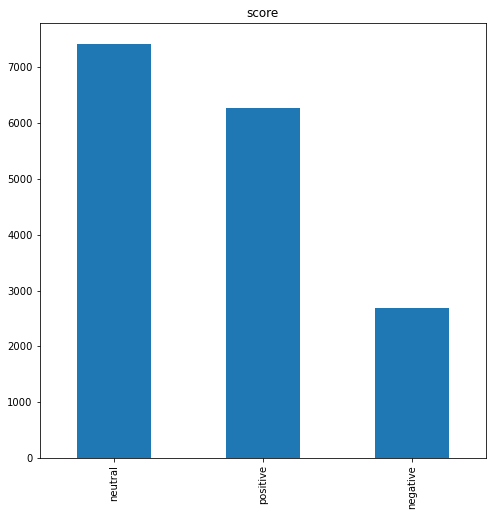

In [19]:
score_count =  cleaned_df['score'].value_counts()
score_count.plot(kind="bar", y="score", title="score", figsize=[8, 8])

In [20]:
def remove_neutral(value):
    return value != "neutral"

### Convert words in text to their root form

In [21]:
stemmer = PorterStemmer()
def stem_word(text: str) -> str:
    
    stemmed_words = []
    sent_list = text.split()
    
    for word in sent_list:
        try:
            stemmed_words.append(stemmer.stem(word)) 
        except:
             stemmed_words.append(word)
    return ' '.join(stemmed_words)

In [24]:
cleaned_df = cleaned_df.astype({"clean_text": str})
cleanedTweet = cleaned_df[cleaned_df['score'].map(remove_neutral)]
cleanedTweet['score'] = cleanedTweet["score"].map( lambda score: 1 if score == "positive" else 0)
cleanedTweet['clean_text'] = cleanedTweet['clean_text'].apply(stem_word)

/tmp/ipykernel_145752/2381445955.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleanedTweet['score'] = cleanedTweet["score"].map( lambda score: 1 if score == "positive" else 0)
/tmp/ipykernel_145752/2381445955.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleanedTweet['clean_text'] = cleanedTweet['clean_text'].apply(stem_word)


In [25]:
(X, y) = cleanedTweet['clean_text'], cleanedTweet['score']

In [26]:
trigram_vectorizer = CountVectorizer(ngram_range=(3, 3))
trigram_vectorizer.fit(X.values)

CountVectorizer(ngram_range=(3, 3))

In [27]:
X_trigram = trigram_vectorizer.transform(X.values)

In [28]:
trigram_tf_idf_transformer = TfidfTransformer()
trigram_tf_idf_transformer.fit(X_trigram)

TfidfTransformer()

In [29]:
X_train_tf_idf = trigram_tf_idf_transformer.transform(X_trigram)

### Model training
* Set train to validation split to 75/25

In [30]:
def train_and_show_scores(X, y, title: str) -> None:
    X_train, X_valid, y_train, y_valid = train_test_split(
        X, y, train_size=0.75, stratify=y
    )

    clf = SGDClassifier()
    clf.fit(X_train, y_train)
    train_score = clf.score(X_train, y_train)
    valid_score = clf.score(X_valid, y_valid)
    print(f'{title}\nTrain score: {round(train_score, 2)} ; Validation score: {round(valid_score, 2)}\n')

In [31]:
train_and_show_scores(X_trigram, y, title="trigram")

trigram
Train score: 0.99 ; Validation score: 0.77



In [32]:
train_and_show_scores(X_train_tf_idf, y, title="trigram_tf_idf")

trigram_tf_idf
Train score: 0.99 ; Validation score: 0.77



We can see from the result above that when using the CountVectorizer and TF-IDF we are getting the same result. Even though TF-IDF is a better vectorizer that CountVectorizer we are getting the same result using this data. We can remove the stop words from the data and test if we get a different result

### Topic Modeling

In [41]:
from pprint import pprint
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import spacy
import pyLDAvis
import pyLDAvis.gensim_models
import nltk 
nltk.download('stopwords')
%matplotlib inline

ModuleNotFoundError: No module named 'pyLDAvis'